### <font color = "darkblue">Detect Credit Card Fraud</font>

## 1 - Packages ##

---

In [199]:
import numpy as np
import pandas as pd
from scipy import stats

from sklearn import linear_model
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score


import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams

RANDOM_SEED = 314
TEST_PCT = 0.2 #20% of data

LABELS = ["Normal", "Fraud"]
rcParams['figure.figsize'] = 14, 8.7

col_list=["cerulean", "crimson"]
col_list_palette = sns.xkcd_palette(col_list)
sns.set(style='whitegrid', font_scale=1.5)
sns.set_palette(col_list_palette)


## 2 - Get CC Dataset ##

In [200]:
df = pd.read_csv("data/creditcard.csv")
df.head(n=5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [201]:
df.shape

(284807, 31)

 ## 3 - Visualize Dataset ##

In [202]:
df.isnull().values.any()

False

In [203]:
count_classes = pd.value_counts(df['Class'], sort = True)
print(count_classes)

0    284315
1       492
Name: Class, dtype: int64


Text(0,0.5,'Frequency')

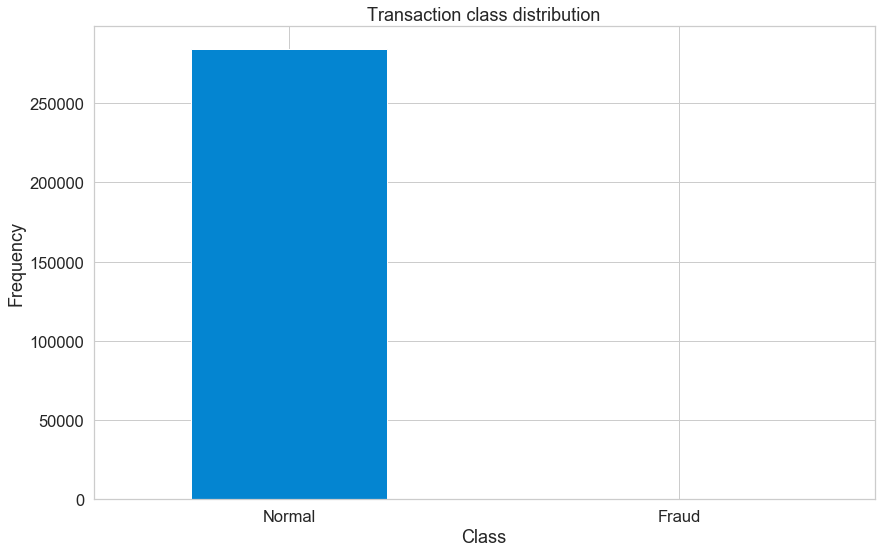

In [204]:
count_classes.plot(kind = 'bar', rot = 0)
plt.xticks(range(2), LABELS)
plt.title("Transaction class distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")


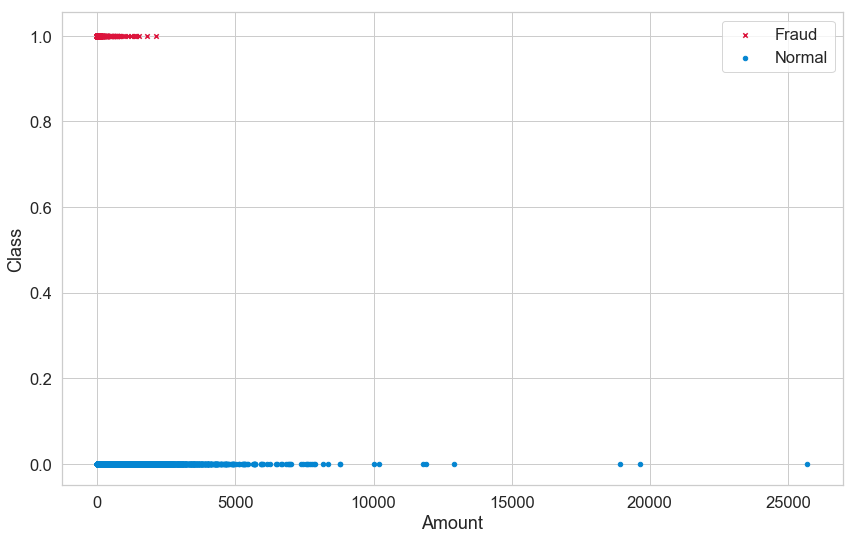

In [205]:
fraud = df[df.Class == 1]
normal = df[df.Class == 0]

ax = fraud.plot(kind ='scatter', marker = 'x',x = 'Amount', y ='Class', color = 'Crimson', label = 'Fraud')
normal.plot(kind = 'scatter', marker = 'o', x = 'Amount', y ='Class',label = 'Normal', ax=ax) 

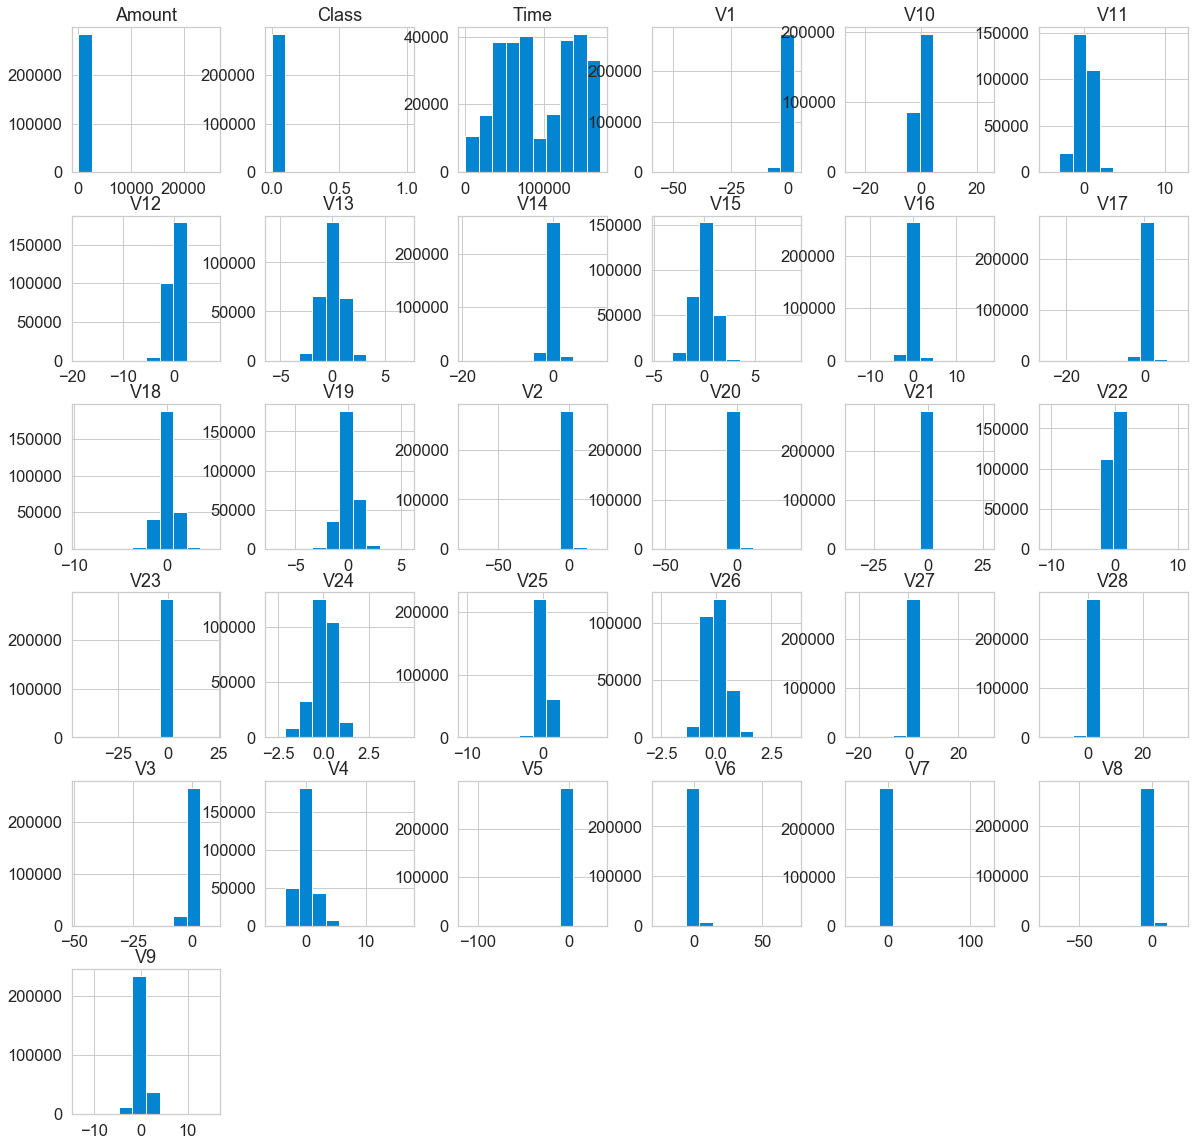

In [206]:
# Plot histograms of each data parameter including y
df.hist(figsize = (20,20))
plt.show()

In [207]:
fraud.shape, normal.shape

((492, 31), (284315, 31))

In [208]:
fraud.Amount.describe()  

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [209]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

/Users/seanitatolliver/.virtualenvs/cv/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


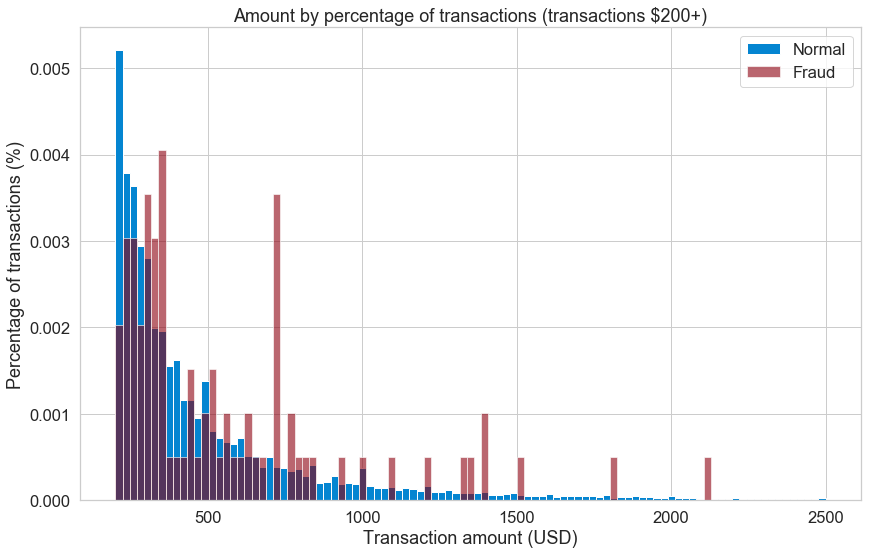

In [210]:
#plot high value transctions
bins = np.linspace(200, 2500, 100)
plt.hist(normal.Amount, bins, alpha=1, normed=True, label='Normal')
plt.hist(fraud.Amount, bins, alpha=0.6, normed=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Amount by percentage of transactions (transactions \$200+)")
plt.xlabel("Transaction amount (USD)")
plt.ylabel("Percentage of transactions (%)");
plt.show()

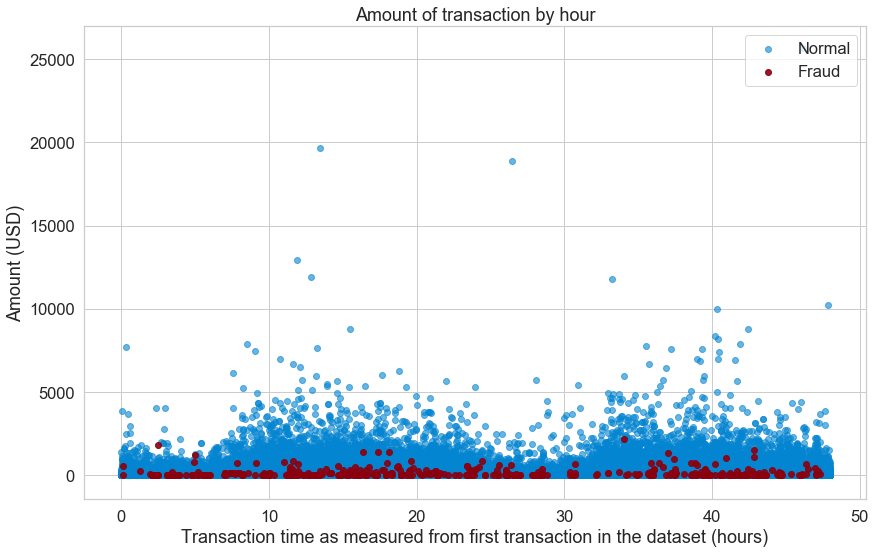

In [211]:
plt.scatter((normal.Time/(60*60)), normal.Amount, alpha=0.6, label='Normal')
plt.scatter((fraud.Time/(60*60)), fraud.Amount, alpha=0.9, label='Fraud')
plt.title("Amount of transaction by hour")
plt.xlabel("Transaction time as measured from first transaction in the dataset (hours)")
plt.ylabel('Amount (USD)')
plt.legend(loc='upper right')
plt.show()

In [212]:
data['normalizedAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data = df.drop(['Time'], axis=1)

X = data.iloc[:, :-1]
y = data['Class']

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 29 columns):
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26       284807 non-null float64
V27  

 ## 4 - Prepare Data ##


In [213]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_PCT, random_state=RANDOM_SEED)


 ## 5 - Apply Models ##


In [214]:
# Logistic regression model
lr = linear_model.LogisticRegression(C=1e5)
lr.fit(X_train, y_train)

# Predicting test set for logistic regression
y_pred = lr.predict(X_test)

print(classification_report(y_test, y_pred, target_names = ['Normal', 'Fraud']))

             precision    recall  f1-score   support

     Normal       1.00      1.00      1.00     56847
      Fraud       0.93      0.57      0.71       115

avg / total       1.00      1.00      1.00     56962



 ## 6 - Visualize Results ##


Text(0.5,49.8,'Predicted class')

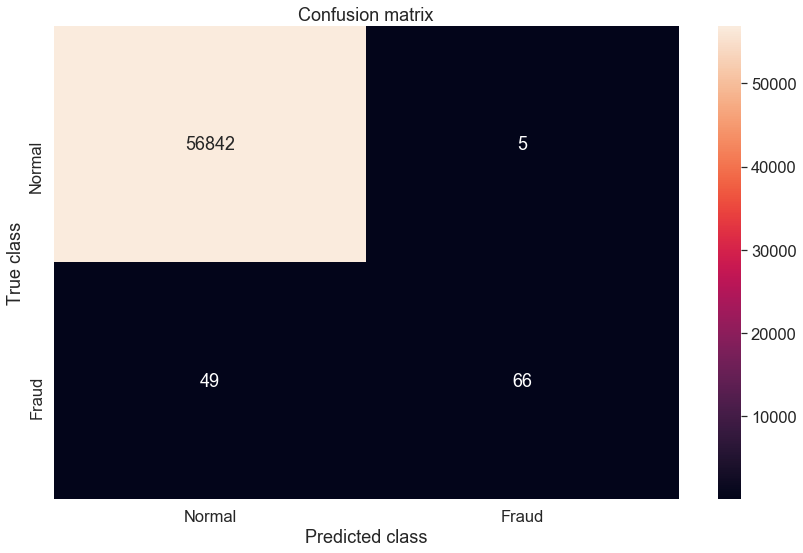

In [215]:
conf_matrix = confusion_matrix(y_test, y_pred) # rows = truth, cols = prediction
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')

 ## 7 - To come...Normalize model and Neural Nets##
